# 프로젝트 : 폐렴 진단기 성능개선


## Step 1. 실험환경 Set-up


In [15]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

ROOT_PATH = '/content/drive/MyDrive/aiffel'
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/content/drive/MyDrive/aiffel


## Step 2. 데이터 준비하기


### 데이터 불러오기

In [17]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
total_len = len(train_filenames)+len(test_filenames)+len(val_filenames)

print('Train :', len(train_filenames), '   Test :',len(test_filenames), '    Validation :',len(val_filenames))
print('Train : {:.3f}%,'.format(len(train_filenames)/total_len),'Test : {:.3f}%,'.format(len(test_filenames)/total_len), 'Validation : {:.3f}%,'.format(len(val_filenames)/total_len))

Train : 5216    Test : 624     Validation : 16
Train : 0.891%, Test : 0.107%, Validation : 0.003%,


> validation set의 개수가 적기 때문에 train과 val에 있는 데이터를 모은 다음 train:val = 8:2로 분할

In [18]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('Train :', len(train_filenames), '   Test :',len(test_filenames), '    Validation :',len(val_filenames))
print('Train : {:.3f}%,'.format(len(train_filenames)/total_len),'Test : {:.3f}%,'.format(len(test_filenames)/total_len), 'Validation : {:.3f}%,'.format(len(val_filenames)/total_len))

Train : 4185    Test : 624     Validation : 1047
Train : 0.715%, Test : 0.107%, Validation : 0.179%,


### TRAIN : 정상 이미지 vs 폐렴 이미지

In [19]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1080
Pneumonia images count in training set: 3105


> 폐렴 이미지가 정상 이미지 보다 3배 더 많음. **CNN 모델의 경위 데이터의 클래스별 밸런스가 좋을수록 학습을 더 잘함**. 뒤에서 조정할 것.

### tf.data 인스턴스 만들기 

tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 함.

In [20]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 이미지 라벨
현재 이미지에는 라벨 데이터가 따로 없고 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수 만들기

In [21]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 이미지 사이즈

사이즈 통일시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈 줄이기

In [22]:
# 이미지 형식
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [23]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [52]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [24]:
# test set도 동일하게 진행
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### tf.data 파이프라인 (효율적으로 사용하기)

|함수|내용|
|--|--|
|`prepare_for_training()`| 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환|
|`shuffle()`|고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택|
|`repeat()`|epoch를 진행하면서 여러 번 데이터셋을 불러올 때, repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용|
|`batch()`|BATCH_SIZE에서 정한 만큼의 배치로 주어짐|
|`prefetch()`|리소스의 유휴 상태를 줄임|
|augmentation|좌우반전|

In [25]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training(train_ds)
val_ds_aug = prepare_for_training(val_ds)

## Step 3. 데이터 시각화


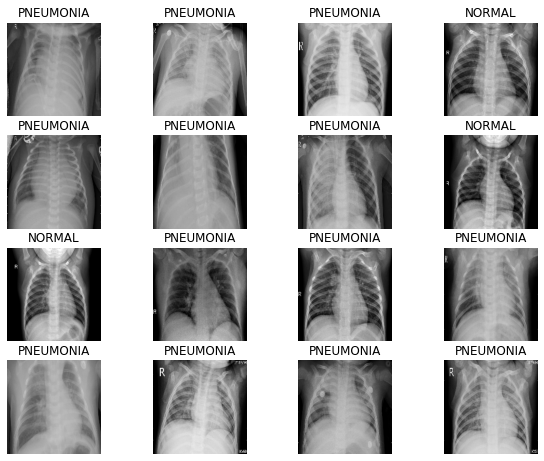

In [13]:
# 좌우반전 적용 x
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

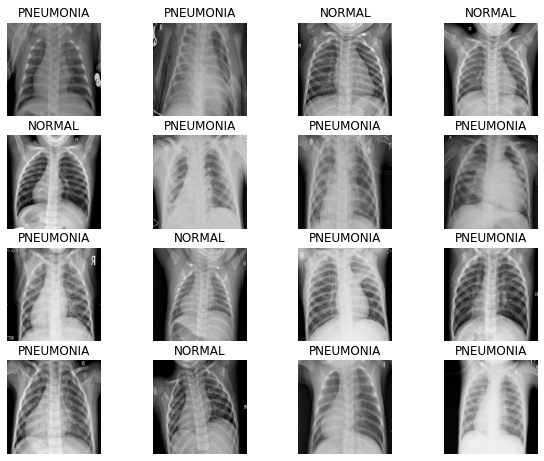

In [26]:
# 좌우반전 적용 o
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_aug))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링


In [27]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [28]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [29]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

하나의 라벨이 너무 많은 경우를 imbalabce 하다고 하고 데이터를 학습할 때, imbalance한 데이터의 경우 학습효과가 좋지 않을 수 있음.

In [30]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

In [31]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 455s 2s/step - loss: 0.3957 - accuracy: 0.8015 - precision: 0.9493 - recall: 0.7737 - val_loss: 0.6043 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 97s 371ms/step - loss: 0.2362 - accuracy: 0.9085 - precision: 0.9686 - recall: 0.9061 - val_loss: 1.1308 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 98s 376ms/step - loss: 0.2240 - accuracy: 0.9159 - precision: 0.9738 - recall: 0.9112 - val_loss: 0.3432 - val_accuracy: 0.8365 - val_precision: 0.8202 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 98s 378ms/step - loss: 0.1888 - accuracy: 0.9320 - precision: 0.9792 - recall: 0.9280 - val_loss: 0.3322 - val_accuracy: 0.8327 - val_precision: 0.8163 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 102s 392ms/step - loss: 0.1743 - accurac

## Step 7. 결과 확인과 시각화


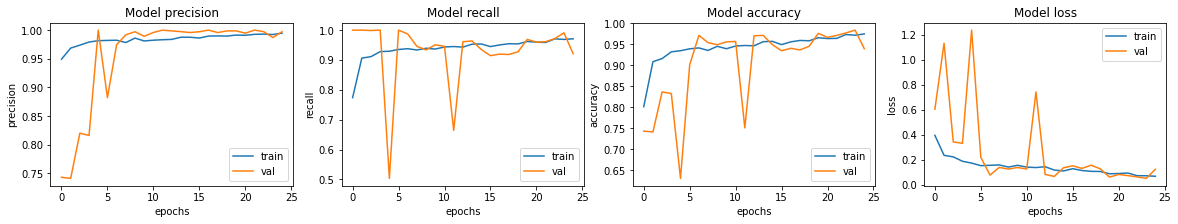

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

> Epoch가 4와 11일 때, accuracy와 recall값이 급락했다가 오르는 모습을 보여줌. 

## Step 8. 테스트 데이터로 모델 평가 

In [34]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 164s 4s/step - loss: 0.4824 - accuracy: 0.8702 - precision: 0.8585 - recall: 0.9487
Loss: 0.48238950967788696,
Accuracy: 0.870192289352417,
Precision: 0.8584686517715454,
Recall: 0.9487179517745972


> 정확도 85% 이상 

In [3]:
F1 = 2*(0.8584686517715454*0.9487179517745972)/(0.8584686517715454+0.9487179517745972)
print(F1)

0.9013398166777694


## 회고 

이번 노드에서 배운내용과 좌우반전을 통해 정확도 87%를 볼 수 있었다. 하지만 그래프로 지표들을 보았을 때, 과연 안정적으로 수렴하고 있는가에 대한 의문이 생겼다. epochs와 bath를 변경해가며 그려보았지만 더 복잡한 그래프가 나왔다. 결국 `BATCH_SIZE = 16, EPOCHS = 25`로 진행하였는데 그나마 그린 그래프중 가장 안정적으로 수렴하고 있는 것 같았다. 특정 회차에서 급락하는 모습을 볼 수 있었는데, 그 이유에 대해 알고 싶고 보기 좋은 그래프를 그리기 위해서는 어떤 과정을 추가하고 제거해야하는지 더 공부하고 싶어지는 익스다 ! 

진단 모델에서는 실제 positive 양성 데이터를 negative로 잘못 표기하면 안되기 때문에 `Recall`값이 중요한데, `Recall`값이 생각보다 엄청 높게 나왔다. F1 score는 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼때 상대적으로 높은 값을 가지는데 런타임이 다되어서 수식으로 계산한 값은 0.9로 꽤 높은 편에 속한다고 생각했다. ! 

안정적인 수렴에 대해 깔끔한 이해가 된 건 아니지만, 의학분야에서 딥러닝이 어떻게 쓰이는지 맛이라도 본 것 같아서 재미있는 익스다.

